In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras
import csv
import pandas as pd
import random
import numpy as np
from keras import regularizers
import re
from tqdm import tqdm_notebook
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
import nltk
nltk.download('wordnet')
import itertools
from string import ascii_lowercase
from functools import reduce
import seaborn as sns
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
train_path='.\\train1.csv'
train=pd.read_csv(train_path)

In [3]:
train.head(20)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [4]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[labels].values  
print(y[:5])

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [5]:
lens=train['comment_text'].str.len()

Text(0, 0.5, 'Number of Comments')

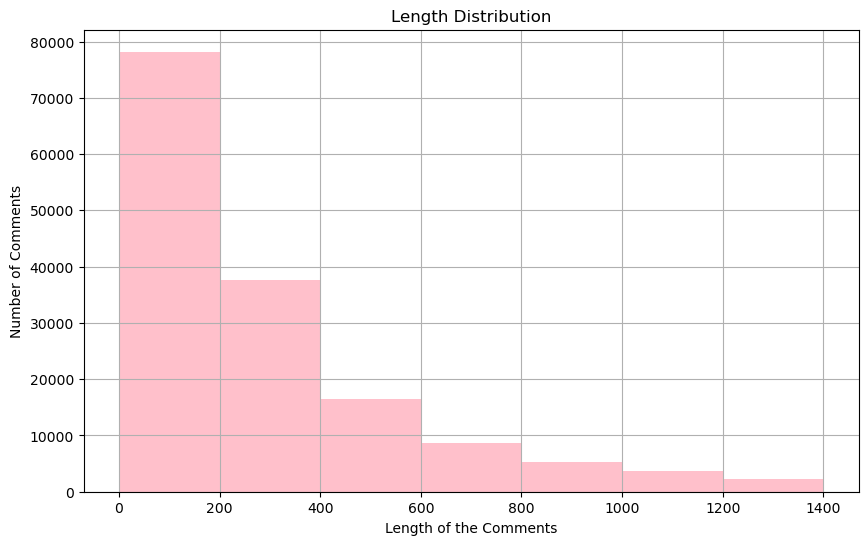

In [6]:
resize = np.arange(0, 1500,200)
lens.hist(color='pink', figsize=(10, 6), bins=resize,width=200 )
plt.title('Length Distribution')
plt.xlabel('Length of the Comments')
plt.ylabel('Number of Comments')

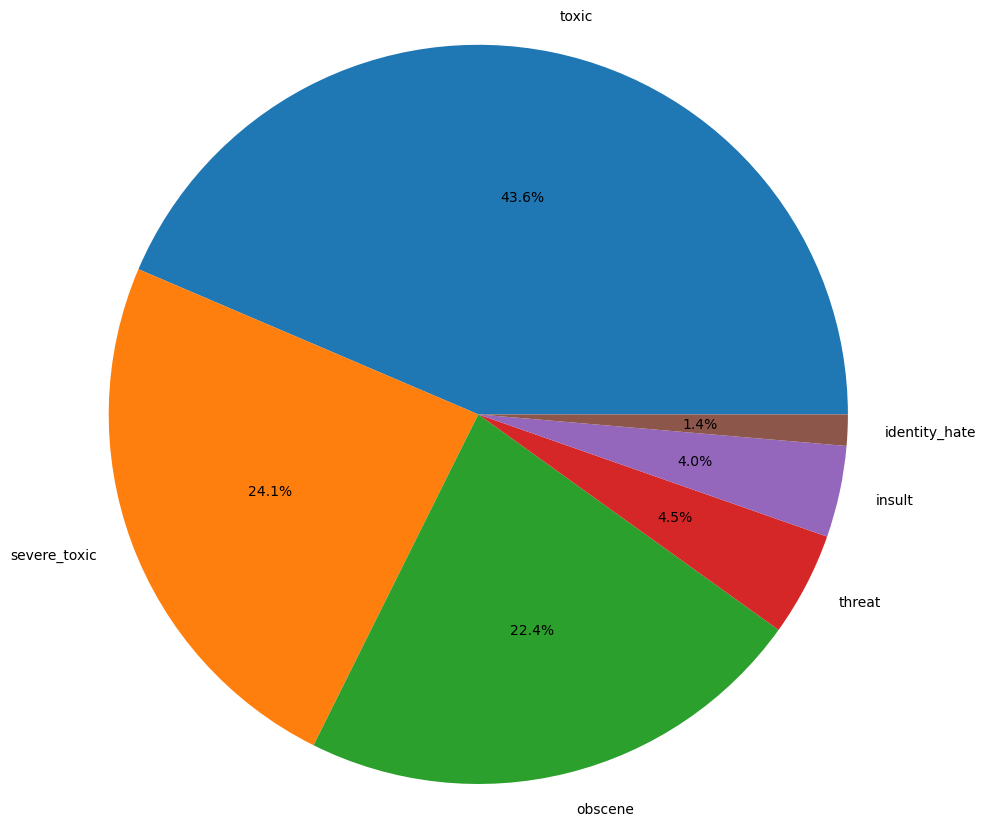

In [7]:
class_cnt = {}
for label in labels:
    class_cnt[label] = len(train[train[label] == 1])
    
class_cnt = {k: v for k, v in sorted(class_cnt.items(), key = lambda item: item[1], reverse = True)}
values=[*class_cnt.values()]
plt.pie(values, labels=labels, radius=2.5,autopct='%1.1f%%')
plt.show()

In [8]:
RE_PATTERNS = {
    ' american ':
        [
            'amerikan'
        ],

    ' adolf ':
        [
            'adolf'
        ],


    ' hitler ':
        [
            'hitler'
        ],

    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*', 
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck','fuk', 'wtf','fucck','f cking'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$'
                                                           '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s'
        ],

    ' asshole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'ass hole'
        ],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h','beetch'
        ],

    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],

    ' transgender':
        [
            'transgender','trans gender'
        ],

    ' gay ':
        [
            'gay'
        ],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k','diick '
        ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ':
        [
            'cunt', 'c u n t'
        ],

    ' bullshit ':
        [
            'bullsh\*t', 'bull\$hit','bs'
        ],

    ' homosexual':
        [
            'homo sexual','homosex'
        ],

    ' jerk ':
        [
            'jerk'
        ],

    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots', 'i d i o t'
        ],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t'
        ],

    ' shithole ':
        [
            'shythole','shit hole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' rape ':
        [
            ' raped'
        ],

    ' dumbass':
        [
            'dumb ass', 'dubass'
        ],

    ' asshead':
        [
            'butthead', 'ass head'
        ],

    ' sex ':
        [
            's3x', 'sexuality',
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],

    ' shut the fuck up':
        [
            'stfu'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' motherfucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker', 'mother fucker'
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e'
        ],
}

In [9]:
##Text Normalization

def clean_text(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True):

  if is_lower:
    text=text.lower()
    
  if remove_patterns_text:
    for target, patterns in RE_PATTERNS.items():
      for pat in patterns:
        text=str(text).replace(pat, target)

  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text) 

  text = str(text).replace("\n", " ")
  text = re.sub(r'[^\w\s]',' ',text)
  text = re.sub('[0-9]',"",text)
  text = re.sub(" +", " ", text)
  text = re.sub("([^\x00-\x7F])+"," ",text)
  return text 

In [10]:
train_texts = [] 
for line in tqdm_notebook(train['comment_text'], total=159571): 
    train_texts.append(clean_text(line))

C:\Users\Dell\AppData\Local\Temp\ipykernel_6148\2701316000.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(train['comment_text'], total=159571):


  0%|          | 0/159571 [00:00<?, ?it/s]

In [11]:
##Lemmatization

lemmatizer= WordNetLemmatizer()
def lemma(text, lemmatization=True):
  output=''
  if lemmatization:
    text=text.split(' ')
    for word in text:
      word1 = lemmatizer.lemmatize(word, pos = "n") #noun 
      word2 = lemmatizer.lemmatize(word1, pos = "v") #verb
      word3 = lemmatizer.lemmatize(word2, pos = "a") #adjective
      word4 = lemmatizer.lemmatize(word3, pos = "r") #adverb
      output=output + " " + word4
  else:
    output=text
  
  return str(output.strip())

In [12]:
lema_train_text=[]
for line in train_texts:
    lema_train_text.append(lemma(line))

In [13]:
##Stopwords Removal

stopword_list=[]
def iter_all_strings():
    for size in itertools.count(1):
        for s in itertools.product(ascii_lowercase, repeat=size):
            yield "".join(s)

dual_alpha_list=[]
for s in iter_all_strings():
    dual_alpha_list.append(s)
    if s == 'zz':
        break

dual_alpha_list.remove('i')
dual_alpha_list.remove('a')
dual_alpha_list.remove('am')
dual_alpha_list.remove('an')
dual_alpha_list.remove('as')
dual_alpha_list.remove('at')
dual_alpha_list.remove('be')
dual_alpha_list.remove('by')
dual_alpha_list.remove('do')
dual_alpha_list.remove('go')
dual_alpha_list.remove('he')
dual_alpha_list.remove('hi')
dual_alpha_list.remove('if')
dual_alpha_list.remove('is')
dual_alpha_list.remove('in')
dual_alpha_list.remove('me')
dual_alpha_list.remove('my')
dual_alpha_list.remove('no')
dual_alpha_list.remove('of')
dual_alpha_list.remove('on')
dual_alpha_list.remove('or')
dual_alpha_list.remove('ok')
dual_alpha_list.remove('so')
dual_alpha_list.remove('to')
dual_alpha_list.remove('up')
dual_alpha_list.remove('us')
dual_alpha_list.remove('we')


for letter in dual_alpha_list:
    stopword_list.append(letter)

In [14]:
print(stopword_list)
print(len(stopword_list))
print(len(lema_train_text))

['b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'aa', 'ab', 'ac', 'ad', 'ae', 'af', 'ag', 'ah', 'ai', 'aj', 'ak', 'al', 'ao', 'ap', 'aq', 'ar', 'au', 'av', 'aw', 'ax', 'ay', 'az', 'ba', 'bb', 'bc', 'bd', 'bf', 'bg', 'bh', 'bi', 'bj', 'bk', 'bl', 'bm', 'bn', 'bo', 'bp', 'bq', 'br', 'bs', 'bt', 'bu', 'bv', 'bw', 'bx', 'bz', 'ca', 'cb', 'cc', 'cd', 'ce', 'cf', 'cg', 'ch', 'ci', 'cj', 'ck', 'cl', 'cm', 'cn', 'co', 'cp', 'cq', 'cr', 'cs', 'ct', 'cu', 'cv', 'cw', 'cx', 'cy', 'cz', 'da', 'db', 'dc', 'dd', 'de', 'df', 'dg', 'dh', 'di', 'dj', 'dk', 'dl', 'dm', 'dn', 'dp', 'dq', 'dr', 'ds', 'dt', 'du', 'dv', 'dw', 'dx', 'dy', 'dz', 'ea', 'eb', 'ec', 'ed', 'ee', 'ef', 'eg', 'eh', 'ei', 'ej', 'ek', 'el', 'em', 'en', 'eo', 'ep', 'eq', 'er', 'es', 'et', 'eu', 'ev', 'ew', 'ex', 'ey', 'ez', 'fa', 'fb', 'fc', 'fd', 'fe', 'ff', 'fg', 'fh', 'fi', 'fj', 'fk', 'fl', 'fm', 'fn', 'fo', 'fp', 'fq', 'fr', 'fs', 'ft', 'fu', 'fv', 'fw', 'fx

In [15]:
def search_stopwords(data, search_stop=True):
  output=""
  if search_stop:
    data=data.split(" ")
    for word in data:
      if not word in stopword_list:
        output=output+" "+word 
  else:
    output=data
  return str(output.strip())

potential_stopwords = []
for line in tqdm_notebook(lema_train_text, total=159571): 
    potential_stopwords.append(search_stopwords(line))
print(len(potential_stopwords))

def string_combine_a(stopword):
  final_a=""
  for item in range(39893):
    final_a=final_a+" "+stopword[item]
  return final_a

def string_combine_b(stopword):
  final_b=""
  for item in range(39893,79785):
    final_b=final_b+" "+stopword[item]
  return final_b

def string_combine_c(stopword):
  final_c=""
  for item in range(79785,119678):
    final_c=final_c+" "+stopword[item]
  return final_c

def string_combine_d(stopword):
  final_d=""
  for item in range(119678,159571):
    final_d=final_d+" "+stopword[item]
  return final_d

total_string_potential_a=string_combine_a(potential_stopwords)
total_string_potential_b=string_combine_b(potential_stopwords)
total_string_potential_c=string_combine_c(potential_stopwords)
total_string_potential_d=string_combine_d(potential_stopwords)

def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    return counts

total_string_potential_a_dict=word_count(total_string_potential_a)
total_string_potential_b_dict=word_count(total_string_potential_b)
total_string_potential_c_dict=word_count(total_string_potential_c)
total_string_potential_d_dict=word_count(total_string_potential_d)

total_string_potential_a_df = pd.DataFrame(list(total_string_potential_a_dict.items()),columns = ['Word','Count'])
total_string_potential_b_df = pd.DataFrame(list(total_string_potential_b_dict.items()),columns = ['Word','Count'])
total_string_potential_c_df = pd.DataFrame(list(total_string_potential_c_dict.items()),columns = ['Word','Count'])
total_string_potential_d_df = pd.DataFrame(list(total_string_potential_d_dict.items()),columns = ['Word','Count'])

top50_potential_stopwords_a=total_string_potential_a_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_b=total_string_potential_b_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_c=total_string_potential_c_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_d=total_string_potential_d_df.sort_values(by=['Count'],ascending=False).head(50)

C:\Users\Dell\AppData\Local\Temp\ipykernel_6148\2329860293.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(lema_train_text, total=159571):


  0%|          | 0/159571 [00:00<?, ?it/s]

159571


In [16]:
#Looking for common terms in all top 50 dataframes.
common_potential_stopwords=list(reduce(set.intersection,map(set,[top50_potential_stopwords_a.Word,top50_potential_stopwords_b.Word,top50_potential_stopwords_c.Word,top50_potential_stopwords_d.Word])))
print(common_potential_stopwords)

['will', 'you', 'use', 'all', 'of', 'wikipedia', 'what', 'or', 'just', 'if', 'there', 'to', 'would', 'your', 'talk', 'for', 'from', 'that', 'by', 'my', 'he', 'so', 'they', 'like', 'we', 'one', 'at', 'on', 'article', 'i', 'please', 'in', 'no', 'and', 'not', 'the', 'a', 'make', 'with', 'an', 'but', 'be', 'do', 'edit', 'about', 'can', 'page', 'have', 'me', 'this']


In [17]:
#Retaining certain words and removing others from the above list.
potential_stopwords=['editor', 'reference', 'thank', 'work','find', 'good', 'know', 'like', 'look', 'thing', 'want', 'time', 'list', 'section','wikipedia', 'doe', 'add','new', 'try', 'think', 'write','use', 'user', 'way', 'page']

#Adding above retrived words into the stopwords list.
for word in potential_stopwords:
    stopword_list.append(word)

In [18]:
def remove_stopwords(text, remove_stop=True):
  output = ""
  if remove_stop:
    text=text.split(" ")
    for word in text:
      if word not in stopword_list:
        output=output + " " + word
  else :
    output=text

  return str(output.strip())

#Removing Stopwords from Train Data
processed_train_data = [] 
for line in tqdm_notebook(lema_train_text, total=159571): 
    processed_train_data.append(remove_stopwords(line))

C:\Users\Dell\AppData\Local\Temp\ipykernel_6148\355063156.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(lema_train_text, total=159571):


  0%|          | 0/159571 [00:00<?, ?it/s]

In [23]:
max_features=148844
maxpadlen = 300        
val_split = 0.2      
embedding_dim_fasttext = 300

In [25]:
#Tokenization
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(processed_train_data))
list_tokenized_train = tokenizer.texts_to_sequences(processed_train_data)

In [26]:
#Indexing
word_index=tokenizer.word_index
print(len(word_index))

148846


In [27]:
#padding
training_padded=pad_sequences(list_tokenized_train, maxlen=maxpadlen, padding = 'post')

In [28]:
print('Tokenized sentences: \n', training_padded[10])
print('One hot label: \n', y[10])

Tokenized sentences: 
 [   77    38   415   130    44    15     2   344     4   401    14   289
    11   242    96    20     8    15    50    97    41   114    81    30
     1   316   195    97     8    28   412    61  4790    51    11    80
 32389   398    11   344    80 32389   398     5   212     9     1   315
   564   478   183   771    59   126     1   147    33     1   195   602
     2  1775    20     8    17    13   126    12   315   194    73     8
    37    74     3   771     1  1489     6     1   195    20     8  1864
    25     4    42    61   330    73     4    79     3     1    42    61
   330    25    49    78   698    19     4  4924     6     9    42    61
   330   219     6     6   147     2   757  1476    93   182    20     1
   195  1561     2   252    25     1    42    61   330  1801    73    84
   195    52    62     2  1348     4    88     4     1    51    41     4
   696   195   615   120    20     1   315   183    15    38   216    20
     8   126    78     1   3

In [29]:
#Splitting data into Training and Validation Set

x_train, x_val, y_train, y_val = train_test_split(training_padded, y, test_size=0.2, random_state=2)

In [30]:
print('Number of entries in each category: ')
print('Training: ', y_train.sum(axis=0))
print('Validation: ', y_val.sum(axis=0))

Number of entries in each category: 
Training:  [12203  1250  6768   388  6328  1138]
Validation:  [3091  345 1681   90 1549  267]


In [43]:
embeddings_index_fasttext = {}
f = open('H:\\python\\text_classification\\wiki-news-300d-1M.vec', encoding='utf8')
for line in f:
    line.encode('utf-8').strip()
    values = line.split()
    word = values[0]
    embeddings_index_fasttext[word] = np.asarray(values[1:], dtype='float32')
f.close()
embedding_matrix_fasttext = np.random.random((len(word_index) + 1, embedding_dim_fasttext))
for word, i in word_index.items():
    embedding_vector = embeddings_index_fasttext.get(word)
    if embedding_vector is not None:
        embedding_matrix_fasttext[i] = embedding_vector

In [44]:
model_1 = tf.keras.Sequential([
	tf.keras.layers.Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings'),
  tf.keras.layers.Input(shape=(maxpadlen, ),dtype='int32'),
  tf.keras.layers.LSTM(40,return_sequences=True, name='lstm_layer'),
  tf.keras.layers.GlobalMaxPooling1D(),
  tf.keras.layers.Dropout(.1),
  tf.keras.layers.Dense(30, activation='relu', kernel_initializer='he_uniform'),
	tf.keras.layers.Dropout(.1),
	tf.keras.layers.Dense(6, activation='sigmoid', kernel_initializer='glorot_uniform')
])
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings (Embedding)      (None, 300, 300)          44654100  
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 lstm_layer (LSTM)           (None, 300, 40)           54560     
                                                                 
 global_max_pooling1d (Globa  (None, 40)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 30)                1230      
                                                        

In [45]:
history_2 = model_1.fit(x_train,y_train, epochs=1, batch_size=264,  validation_data=(x_val, y_val))

484/484 [==============================] - 633s 1s/step - loss: 0.1369 - accuracy: 0.6622 - val_loss: 0.0545 - val_accuracy: 0.9944


In [46]:
sub = pd.read_csv(".\\test.csv")

In [47]:
sub=sub[0:10]

In [48]:
sub.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [49]:
c=0
clean=[]
for i in sub['comment_text']:
  i=clean_text(i)
  i=lemma(i)
  i=remove_stopwords(i)
  clean.append(i)

In [50]:
sub['Cleaned_Comments']=clean

In [51]:
sub.head()

,id,comment_text,Cleaned_Comments
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,bitch rule be more succesful then you ever be ...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,from rfc the title be fine a be imo
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",source zawe ashton on lapland
3,00017563c3f7919a,":If you have a look back at the source, the in...",if you have a back at the source the informati...
4,00017695ad8997eb,I don't anonymously edit articles at all.,i don anonymously edit article at all


In [52]:
X_ = tokenizer.texts_to_sequences(sub['Cleaned_Comments'])
test_padded = pad_sequences(X_, maxlen=maxpadlen, truncating='post')
pred = model_1.predict(test_padded)

1/1 [==============================] - 1s 1s/step


In [53]:
type(pred)

numpy.ndarray

In [54]:
sub['score']=0.0

In [55]:
for i in range(len(pred)):
    sub['score'][i]=pred[i][0]+pred[i][1]+pred[i][2]+pred[i][3]+pred[i][4]+pred[i][5]

C:\Users\Dell\AppData\Local\Temp\ipykernel_6148\1952681217.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['score'][i]=pred[i][0]+pred[i][1]+pred[i][2]+pred[i][3]+pred[i][4]+pred[i][5]


In [56]:
for i in range(len(pred)):
    print(pred[i][0])
    print(pred[i][1])
    print(pred[i][2])
    print(pred[i][3])
    print(pred[i][4])
    print(pred[i][5])

0.956895
0.21823536
0.84809315
0.02394865
0.7929651
0.120691285
0.10670237
0.002959246
0.018743169
0.0027380032
0.022567088
0.0047669355
0.10363674
0.002519565
0.018894639
0.002347181
0.021030676
0.004208568
0.013615789
0.0009485621
0.002031134
0.001956175
0.0030251117
0.0017262214
0.09113745
0.0023538095
0.015954167
0.0023073766
0.0191201
0.004248329
0.103197835
0.0032616819
0.018282285
0.0034762495
0.02368043
0.0054335617
0.058444228
0.002374208
0.009535965
0.0032741777
0.012781569
0.0035728936
0.55680656
0.014550595
0.19224654
0.0064409003
0.18179831
0.019124338
0.05279096
0.0027212147
0.009235998
0.0035884469
0.013018953
0.0040843426
0.06536612
0.002949549
0.012152533
0.003971632
0.0159312
0.004558818


In [57]:
sub.head()

,id,comment_text,Cleaned_Comments,score
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,bitch rule be more succesful then you ever be ...,2.960829
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,from rfc the title be fine a be imo,0.158477
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",source zawe ashton on lapland,0.152637
3,00017563c3f7919a,":If you have a look back at the source, the in...",if you have a back at the source the informati...,0.023303
4,00017695ad8997eb,I don't anonymously edit articles at all.,i don anonymously edit article at all,0.135121


In [58]:
for i in range(len(pred)):
  if sub['score'][i]>1:
    sub['score'][i]=1

C:\Users\Dell\AppData\Local\Temp\ipykernel_6148\3117347041.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['score'][i]=1


In [59]:
sub.drop(['comment_text'],axis=1,inplace=True)
sub.drop(['Cleaned_Comments'],axis=1,inplace=True)

In [60]:
sub.head()

,id,score
0,00001cee341fdb12,1.000000
1,0000247867823ef7,0.158477
2,00013b17ad220c46,0.152637
3,00017563c3f7919a,0.023303
4,00017695ad8997eb,0.135121
